John-Henry Pezzuto - PS #5

In [2]:
#packages
import numpy as np
import scipy.optimize as opt
import scipy.stats as sts
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import scipy.integrate as intgr
import numpy.linalg as lin
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from pandas import Series, DataFrame


#logistic regression packages
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.metrics import classification_report
from pylab import rcParams
from scipy.interpolate import LSQUnivariateSpline
import seaborn as sb



plt.style.use("ggplot")
%matplotlib inline

#data

strongdrink = pd.read_csv("data/strongdrink.txt")
CoolIndex = pd.read_csv('data/CoolIndex.txt', header=None)


/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## (a) Use a multinomial logistic regression model

In [3]:
strongdrink['const']=1
X = strongdrink[['const','alco', 'malic', 'tot_phen', 'color_int']]
y = strongdrink['cultivar']


X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size = 0.25,
random_state=20)

LogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
LogReg.fit(X_train, y_train)
y_pred = LogReg.predict(X_test)

print(classification_report(y_test, y_pred))
# Note that the squared doesn't matter in a Logistic model

print('Validation set MSE = ', mean_squared_error(y_test, y_pred))
print (f'The error rate for j=1 is {1-0.87} and the error rate for j=2 is 0')
print('\n')
print(f'The betas for j=1 are {LogReg.coef_[0]}')
print(f'The betas for j=2 are {LogReg.coef_[1]}')

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44

Validation set MSE =  0.0454545454545
The error rate for j=1 is 0.13 and the error rate for j=2 is 0


The betas for j=1 are [ -8.45998080e-06   1.70038994e+00  -2.65604001e-01   1.22389318e+00
   2.27585993e-02]
The betas for j=2 are [ -1.76923789e-05  -1.46805313e+00  -3.33053748e-01   6.64013944e-01
  -9.22712974e-01]


j=2 and j=3 have perfect precision of 1, however j=3 has better recall score making it the category we can predict best. j=2 has the most (71) observations while j=3 has fewest (46) observations. Therefore we can see that the most accurately predicted category is not the one with the most observations.

## (b) Perform a leave-one-out cross validation (LOOCV)

In [8]:
# Define loo as a leave-one-out object, then
# split it into N different partitions

# Note that the LeaveOneOut() function does not work
# well with pandas DataFrames
Xvars = strongdrink.ix[:, (1, 2, 6, 10)].values
yvals = strongdrink.ix[:, 0].values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
y_test_vec = np.zeros(N_loo)
y_pred_vec = np.zeros(N_loo)

# This loop will take 20 or 30 seconds
for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec[test_index] = (y_test != y_pred)
    y_pred_vec[test_index] = y_pred
    y_test_vec[test_index] = y_test
    
MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()

print(classification_report(y_test_vec, y_pred_vec))
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

print(f'The average error rate for category 1 is {1-.9}')
print(f'The average error rate for category 2 is {1-.91}')
print(f'The average error rate for category 3 is {1-.96}')

             precision    recall  f1-score   support

        1.0       0.90      0.93      0.92        59
        2.0       0.91      0.90      0.91        71
        3.0       0.96      0.93      0.95        46

avg / total       0.92      0.92      0.92       176

test estimate MSE loocv= 0.0795454545455 , test estimate MSE standard err= 0.270588202268
The average error rate for category 1 is 0.09999999999999998
The average error rate for category 2 is 0.08999999999999997
The average error rate for category 3 is 0.040000000000000036


The error rates for cultivar = 1 becomes smaller, while the others become larger compared with multinomial regression

## (c) Perform a k-fold cross validation

In [9]:
k=4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(Xvars)
MSE_vec_kf = np.zeros(k)

k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    print(classification_report(y_test, y_pred))
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()

print('\nthe average error rate for class 1 is ', 1- (0.71 + 1.00 + 0.94 + 0.88)/4)
print('the average error rate for class 2 is ', 1- (1.00 + 0.69 + 0.94 + 1.00)/4)
print('the average error rate for class 3 is ', 1- (0.78 + 1.00 + 1.00 + 1.00)/4)

k index= 0
MSE for test set 0  is 0.159090909091
             precision    recall  f1-score   support

          1       0.71      1.00      0.83        12
          2       1.00      0.75      0.86        24
          3       0.78      0.88      0.82         8

avg / total       0.88      0.84      0.84        44

k index= 1
MSE for test set 1  is 0.113636363636
             precision    recall  f1-score   support

          1       1.00      0.76      0.87        17
          2       0.69      1.00      0.81        11
          3       1.00      0.94      0.97        16

avg / total       0.92      0.89      0.89        44

k index= 2
MSE for test set 2  is 0.0454545454545
             precision    recall  f1-score   support

          1       0.94      1.00      0.97        15
          2       0.94      0.94      0.94        16
          3       1.00      0.92      0.96        13

avg / total       0.96      0.95      0.95        44

k index= 3
MSE for test set 3  is 0.045454545454

The error rate for cultivar = 1 is larger than part b but smaller than part a 


The error rate for cultivar = 2 is smaller than part b but larger than part a


The error rate cultivar = 3 is also smaller than part b but larger than part a.

In [11]:
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.0909090909091 test estimate MSE standard err= 0.04821182599


# 2. Spline and kernel density interpolation (4 points)

### (a) Create a scatterplot

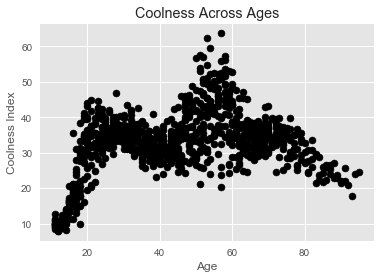

In [12]:
CoolIndex.columns = ['age', 'coolness']
age = CoolIndex['age']
coolness = CoolIndex['coolness']
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)

plt.scatter(age, coolness, color='black')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Across Ages')
plt.show()

### (b) Use ordinary least squares (OLS) regression

In [13]:
age_11_22 = ((age >= 11) & (age < 22)).astype(int)
age_22_40 = ((age >= 22) & (age < 40)).astype(int)
age_40_59 = ((age >= 40) & (age < 59)).astype(int)
age_59_77 = ((age >= 59) & (age < 77)).astype(int)
age_77_95 = ((age >= 77) & (age <= 95) ).astype(int)
X_step = pd.DataFrame(dict(age_22_40=age_22_40, age_11_22=age_11_22,
                           age_40_59=age_40_59, age_59_77=age_59_77,
                           age_77_95=age_77_95))

reg2 = sm.OLS(endog=coolness, exog=X_step, missing='drop')
reg2_results = reg2.fit()
y_pred_1 = reg2_results.predict(X_step)
print(reg2_results.summary())

                            OLS Regression Results                            
Dep. Variable:               coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 19 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        08:53:53   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_11_22     20.1025      0.562     35.746      0.0

In [20]:
b1, b2, b3, b4, b5 = reg2_results.params
print('b1 =', b1, ', b2 =', b2,
      ', b3 =', b3, ', b4 =', b4,
      ', b5 =', b5)

print('Predicted Coolness of 73-year old is', reg2_results.params[3])

b1 = 20.1024572521 , b2 = 34.4757880776 , b3 = 37.6351054924 , b4 = 35.2254000402 , b5 = 27.2963782443
Predicted Coolness of 73-year old is 35.2254000402


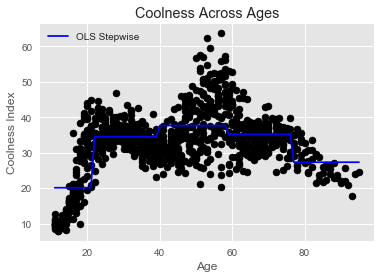

In [21]:
plt.scatter(age, coolness, label=None, color='black')
plt.plot(CoolIndex.age, y_pred_1, color = 'b', label='OLS Stepwise')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Across Ages')
plt.legend(loc='upper left')
plt.show()

### (c) Fit a linear spline (continuous)

In [22]:
knots = [22, 40, 59, 77]
spl_linear = LSQUnivariateSpline(age.values, coolness.values, knots, k=1)
y_pred_2 = spl_linear(age)


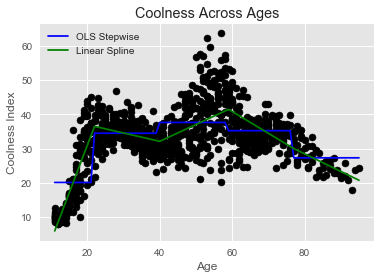

In [23]:
plt.scatter(age, coolness, label=None, color='black')
plt.plot(CoolIndex.age, y_pred_1, color = 'b', label='OLS Stepwise')
plt.plot(CoolIndex.age, y_pred_2, color = 'green', label='Linear Spline')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Across Ages')
plt.legend(loc='upper left')
plt.show()

In [89]:
print('Predicted Coolness of 73-year old is', spl_linear(73))

Predicted Coolness of 73-year old is 32.536832389143306


### (d) Fit a cubic spline (continuous)

In [92]:
spl_cubic = LSQUnivariateSpline(age.values, coolness.values, knots, k=3)
y_pred_3 = spl_cubic(CoolIndex.age)

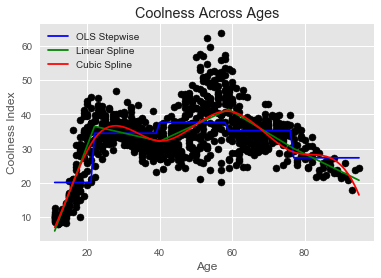

In [95]:
plt.scatter(age, coolness, label=None, color='black')
plt.plot(CoolIndex.age, y_pred_1, color = 'b', label='OLS Stepwise')
plt.plot(CoolIndex.age, y_pred_2, color = 'green', label='Linear Spline')
plt.plot(CoolIndex.age, y_pred_3, color = 'red',label='Cubic Spline')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness Across Ages')
plt.legend(loc='upper left')
plt.show()

In [96]:
print('Predicted Coolness of 73-year old =', spl_cubic(73))

Predicted Coolness of 73-year old = 31.262429389257864
